# Sentiment arcs of movies

In [2]:
%matplotlib inline
import os
import re
from glob import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from sklearn import preprocessing, metrics
import nltk
import nltk.sentiment
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True);

In [3]:
# Load the English sentiment lexicon by Bing Liu
# https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
with open('lists/positive-words.txt') as inp:
    positive_words = set(inp.read().splitlines())
with open('lists/negative-words.txt') as inp:
    negative_words = set(inp.read().splitlines())
lexicon = (positive_words, negative_words)    

In [4]:
def get_script(link):
    """Download web page and return text of first <pre> element.
    Works with http://www.imsdb.com."""
    resp = requests.get(link)
    soup = BeautifulSoup(resp.text, 'html.parser')
    pre = soup.find('pre')
    return pre.text


def read_script(fname):
    """Read a plain text file, split text into sentences,
    return as pandas Series object."""
    with open(fname, encoding='utf8') as inp:
        text = inp.read()
    # Remove single linebreaks and other whitespace;
    # keep double linebreaks to preserve paragraphs
    text = re.sub(r' *\n *', ' ', text.lower())
    lines = nltk.sent_tokenize(text)
    return pd.Series([line.strip() for line in lines])
    return preprocess(text)


def read_subtitles(fname):
    """Clean up subtitles in SRT format.
    Cf. https://en.wikipedia.org/wiki/SubRip
    
    :returns: a Series object with preprocessed subtitle text (lowercased, linebreaks removed).
        The index contains the end timestamp of the subtitle.
    """
    with open(fname, encoding='latin1') as inp:
        text = inp.read()
    matchsubtitle = re.compile(
        r"""^\d+\n                           # the sequence ID
            ([\d:,]+)[ ]-->[ ]([\d:,]+)\n    # start and end timestamp
            ((?:[^\n]+\n){1,2})              # the text of the subtitles
        """,
        flags=re.MULTILINE | re.VERBOSE)
    cleantags = re.compile('<.*?>')  # remove HTML, <i>emphasis</i> etc.
    result = pd.DataFrame(matchsubtitle.findall(text), columns=['start', 'end', 'text'])
    result.index = pd.to_timedelta([a.replace(',', '.') for a in result['end']])
    result['text'] = [cleantags.sub('', a.lower().replace('\n', ' ').strip())
                      for a in result['text']]
    return result['text']


def stripfname(path):
    """Return filename without directories and extension."""
    return os.path.splitext(os.path.basename(path))[0]


def map_sentiment_lexicon(lines, positive_words, negative_words):
    """Given a list of sentences, return a Series with sentiment scores."""
    sentiment = []
    for line in lines:
        score = 0
        tokens = nltk.word_tokenize(line)
        for token in tokens:
            if token.lower() in positive_words:
                score += 1
            elif token.lower() in negative_words:
                score -= 1
        sentiment.append(score / len(tokens))
    return pd.Series(sentiment, index=lines.index)


def map_sentiment_vader(lines):
    """Given a list of sentences, return a Series with sentiment scores between -1 and 1."""
    sid = nltk.sentiment.vader.SentimentIntensityAnalyzer()
    sentiment = []
    for line in lines:
        scores = sid.polarity_scores(line)
        sentiment.append(scores['compound'])
    return pd.Series(sentiment, index=lines.index)


def map_sentiment(sents, method='lexicon', lexicon=None):
    """Apply sentiment analysis to each line in text.
    
    :param sents: a Series or list of strings with sentences.
    :param method: method used for sentiment analysis; 'lexicon' or 'vader'.
    :param positive_words: and negative_words, only needed when method='lexicon'
    :returns: Series with sentiment score (-1, 0, 1) for each line.
    """
    if method == 'lexicon':
        positive_words, negative_words = lexicon
        series = map_sentiment_lexicon(sents, positive_words, negative_words)
    elif method == 'vader':
        series = map_sentiment_vader(sents)
    else:
        raise ValueError('unknown method')
    return series


def discretize_score(score, threshold):
    """Map a continuous sentiment score on a scale of -1 to 1
    to a discrete label of -1, 0, or 1.
    Threshold is the cutoff to use."""
    if score < -threshold:
        return -1
    elif score > threshold:
        return 1
    return 0


def sentiment_arc(series, window=500, min_periods=50, normalize=False, scale=False, name=None):
    """Turn a Series of sentiment scores into an emotional arc using a rolling mean.
    
    :param series: a Series object with sentiment scores as values.
    :param window: the number of datapoints for the moving average (mean);
        higher values amount to more smoothing.
        If the Series object has timestamps as index, this can also be an interval,
        for example window='10min'
    :param min_periods: the minimal number of datapoints for the rolling mean
    :param normalize: if True, convert the index (sentence numbers or timestamps)
        into percentages. Useful to compare texts/movies of different lengths.
    :param scale: Whether to scale the sentiment scores to the range [-1, 1];
        (i.e., ensure stddev=1).
    :param name: optionally, a name for the returned Series; used in the legend of plots.
    :returns: a Series where each value represents the mean sentiment score
        of the previous n values (where n equals window). The index is equal to the
        index of the original series (when normalize=False),
        or it is a percentage (when normalize=True).
    """
    if scale:
        series = pd.Series(
            preprocessing.scale(series, copy=True, with_mean=False, with_std=True),
            index=series.index)
    # NB: only report a rolling average after `window` sentences;
    # for sentences 1-`window`, we don't have enough data to report a reliable average.
    arc = series.rolling(window, min_periods=min_periods).mean()
    if normalize:
        if isinstance(arc.index[0], int):  # sentence numbers
            arc.index = 100 * arc.index.to_series() / len(arc)
        elif isinstance(arc.index[0], pd.Timedelta):  # timestamps
            arc.index = 100 * arc.index / arc.index[-1]
        else:
            raise ValueError('unknown index type, cannot normalize')
    if name:
        arc.name = name
    return arc


def plot_subtitles_vs_script(script, subtitles,
            method='vader', lexicon=lexicon, script_window=500, sub_window='10min', normalize=True, scale=True):
    fig, ax = plt.subplots(figsize=(8, 4))
    text1 = read_script(script)
    text2 = read_subtitles(subtitles)
    sent1 = map_sentiment(text1, method=method, lexicon=lexicon)
    sent2 = map_sentiment(text2, method=method, lexicon=lexicon)
    arc1 = sentiment_arc(sent1, name=stripfname(script) + ' script', window=script_window, normalize=normalize, scale=scale)
    arc2 = sentiment_arc(sent2, name=stripfname(script) + ' subtitles', window=sub_window, normalize=normalize, scale=scale)
    arc1.plot(color='red', ax=ax)
    arc2.plot(color='blue', ax=ax)
    ax.legend()
    ax.set_xlabel('sentence (%)')
    ax.set_ylabel('sentiment score (%s)' % method);
    return fig


def plot_multiple_scripts(scripts,
            method='vader', lexicon=lexicon, window=400, normalize=True, scale=True):
    fig, ax = plt.subplots(figsize=(8, 4))
    for script in scripts:
        text = read_script(script)
        sent = map_sentiment(text, method=method, lexicon=lexicon)
        arc = sentiment_arc(sent, name=stripfname(script), window=window, normalize=normalize, scale=scale)
        arc.plot(ax=ax)
    # Put legend outside plot https://stackoverflow.com/a/4701285
    # Shrink current axis width by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    ax.set_title('movie scripts')
    ax.set_xlabel('sentence (%)')
    ax.set_ylabel('sentiment score (%s)' % method);
    return fig


def plot_multiple_subtitles(subtitles,
            method='vader', lexicon=lexicon, window='10min', normalize=False, scale=True):
    fig, ax = plt.subplots(figsize=(8, 4))
    for sub in subtitles:
        text = read_subtitles(sub)
        sent = map_sentiment(text, method=method, lexicon=lexicon)
        arc = sentiment_arc(sent, name=stripfname(sub), window=window, normalize=normalize, scale=scale)
        arc.plot(ax=ax)
    # Put legend outside plot https://stackoverflow.com/a/4701285
    # Shrink current axis width by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    if not normalize:
        # abbreviate timestamps https://stackoverflow.com/a/23088383
        xtl = [item.get_text()[7:15] for item in ax.get_xticklabels()]
        ax.set_xticklabels(xtl)
    ax.set_title('subtitles')
    ax.set_xlabel('movie time (%)' if normalize else 'movie time')
    ax.set_ylabel('sentiment score (%s)' % method);
    return fig

## 1. Data collection

Two types of data can be used:

- movie scripts (also known as screenplays);
  - plain text scripts are availabe at www.imsdb.com (see below how to download them)
  - PDF versions of scripts are available at www.scriptslug.com (convert them to plain .txt yourself)
  - NB: some websites present a transcript of dialogue as the movie script, but in this case it is better to use subtitles
- movie subtitles in .srt format (the most common format)
  - see for example http://www.opensubtitles.com/
  - many other websites; e.g., Google for ``subtitles <name of movie>``
  - download the .srt files to the same directory as this notebook


In [4]:
# Downloading a collection of movie scripts

os.makedirs('action', exist_ok=True)
os.makedirs('drama', exist_ok=True)

# A dictionary of movie scripts.
# Key: filename; Value: the link of a script.
scripts = {
    # filename: link,
    'action/Star Wars A New Hope (1977).txt': 'https://www.imsdb.com/scripts/Star-Wars-A-New-Hope.html',
    'action/The Dark Knight (2008).txt': 'https://archive.org/stream/TheDarkKnightScriptByJonathanNolanAndChristopherNolan/The+Dark+Knight+Script+by+Jonathan+Nolan+And+Christopher+Nolan_djvu.txt',
    'drama/Syriana (2005).txt': 'https://www.imsdb.com/scripts/Syriana.html',
}

# PDFs downloaded from:
# https://cinephiliabeyond.org/a-history-of-violence/
# https://www.simplyscripts.com/scripts/TheDancerUpstairs.pdf
# converted with following command (Linux):
# pdftotext -layout "A History of Violence (2005).pdf"

for fname, link in scripts.items():
    # Do not download the script again if it already exists
    if not os.path.exists(fname):
        text = get_script(link)
        with open(fname, 'w', encoding='utf8') as out:
            out.write(text)

In [5]:
# Example of reading subtitles
text = read_subtitles('mi.srt')
text[10:20]

0 days 00:04:00.284000                                       no, thank you.
0 days 00:04:08.626000         would you like to watch a movie, mr. phelps?
0 days 00:04:10.669000                            no, i prefer the theater.
0 days 00:04:13.464000        would you consider the cinema of the ukraine?
0 days 00:04:17.426000                    perhaps you'll choose one for me.
0 days 00:04:23.265000                                           thank you.
0 days 00:04:50.209000                            good morning, mr. phelps.
0 days 00:04:53.128000    the man you're looking at is alexander golitsy...
0 days 00:04:55.631000                 an attaché at our embassy in prague.
0 days 00:04:57.508000                                he is also a traitor.
Name: text, dtype: object

In [6]:
glob('action/*.srt')

['action/Star Wars 4 A New Hope (1977).srt',
 'action/The Dark Knight (2008).srt',
 'action/A History of Violence (2005).srt']

In [7]:
glob('action/*.txt')

['action/The Dark Knight (2008).txt',
 'action/Star Wars A New Hope (1977).txt',
 'action/A History of Violence (2005).txt']

In [8]:
glob('drama/*.srt')

['drama/Girl Interrupted (1999).srt',
 'drama/Syriana (2005).srt',
 'drama/The Dancer Upstairs (2002).srt']

In [9]:
glob('drama/*.txt')

['drama/The Dancer Upstairs (2002).txt', 'drama/Syriana (2005).txt']

## 2. Plotting sentiment arcs

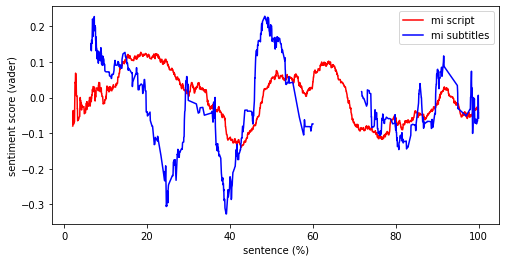

In [10]:
fig = plot_subtitles_vs_script('mi.txt', 'mi.srt')
# fig.savefig('mi.pdf')

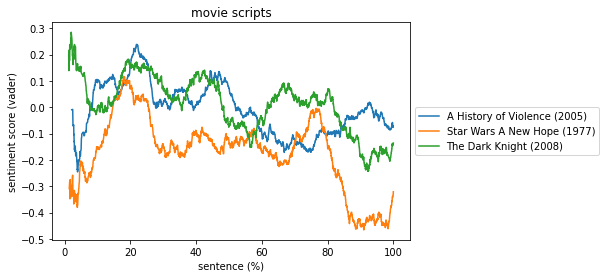

In [26]:
fig = plot_multiple_scripts(sorted(glob('action/*.txt')))

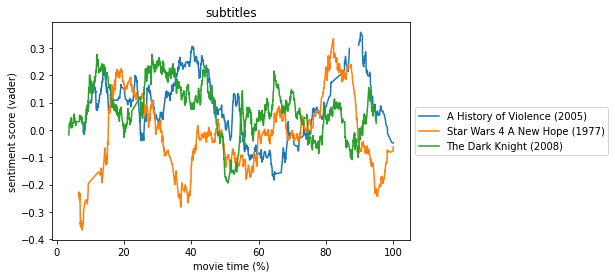

In [25]:
fig = plot_multiple_subtitles(sorted(glob('action/*.srt')), normalize=True)

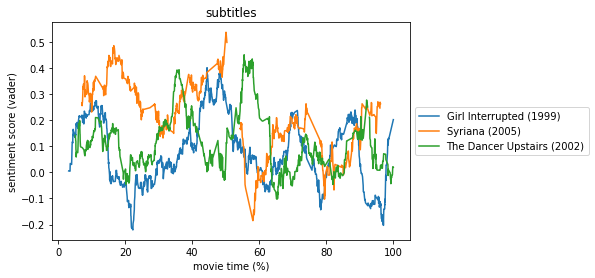

In [13]:
fig = plot_multiple_subtitles(glob('drama/*.srt'), normalize=True)

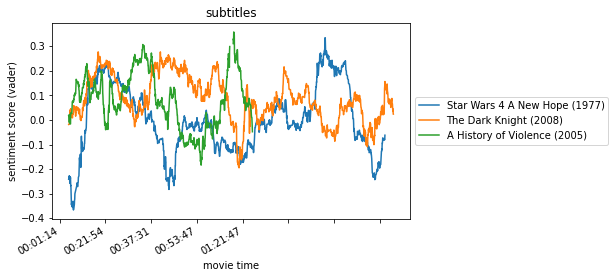

In [14]:
fig = plot_multiple_subtitles(glob('action/*.srt'))

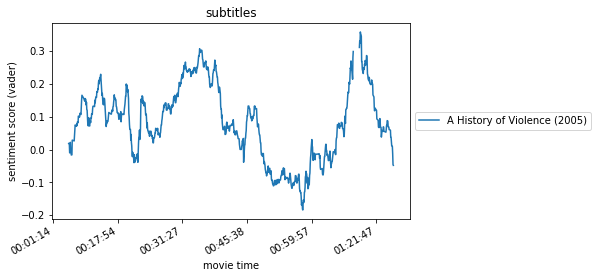

In [15]:
fig = plot_multiple_subtitles(['action/A History of Violence (2005).srt'])

## 3. Validation

In [16]:
# Read subtitles
subtitles = read_subtitles('drama/Girl Interrupted (1999).srt')
subtitles[101:200]

0 days 00:06:54.815000                                  four days ago,
0 days 00:06:58.552000                  you chased a bottle of aspirin
0 days 00:07:02.623000                               i had a headache.
0 days 00:07:06.994000                                        susanna,
0 days 00:07:10.330000                your father is a friend of mine.
                                              ...                     
0 days 00:14:29.236000                                      all right.
0 days 00:14:32.105000                            ah, the living room.
0 days 00:14:34.241000                              everyone hates it.
0 days 00:14:46.886000                       and these are the phones.
0 days 00:14:50.590000    you need to make a call, pick up the handle,
Name: text, Length: 99, dtype: object

In [17]:
# Read annotations
annotations = pd.read_excel('girl, interrupted (1999).xlsx', index_col=0)
annotations.index = pd.to_timedelta([str(a) for a in annotations.index])
annotations = annotations['Sentiment'] - 2  # convert labels 1, 2, 3 to -1, 0, 1, respectively
annotations

0 days 00:01:00    0
0 days 00:02:00    0
0 days 00:03:00   -1
0 days 00:04:00    0
0 days 00:05:00    1
                  ..
0 days 01:57:00    0
0 days 01:58:00    0
0 days 01:59:00    1
0 days 02:00:00    0
0 days 02:01:00    0
Name: Sentiment, Length: 121, dtype: int64

In [18]:
# Inspecting the annotations
annotations.value_counts()

 0    65
-1    43
 1    13
Name: Sentiment, dtype: int64

### 3a Visual evaluation

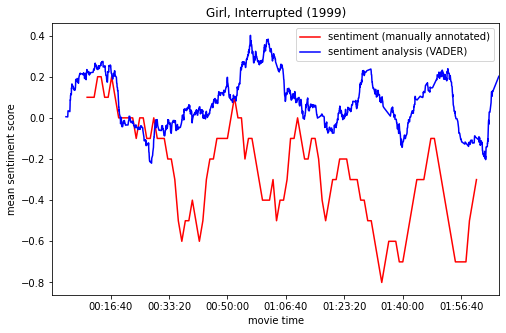

In [19]:
# Comparing sentiment arcs of annotations and subtitles; with VADER method
estimated_sentiments = map_sentiment(subtitles, method='vader')
arc1 = sentiment_arc(annotations, window='10min', min_periods=10, normalize=False, scale=False)
arc2 = sentiment_arc(estimated_sentiments, window='10min', normalize=False, scale=True)
fig, ax = plt.subplots(figsize=(8, 5))
arc1.plot(label='sentiment (manually annotated)', color='red', ax=ax)
arc2.plot(label='sentiment analysis (VADER)', color='blue', ax=ax)
ax.legend()
ax.set_title('Girl, Interrupted (1999)')
ax.set_xlabel('movie time')
ax.set_ylabel('mean sentiment score');
fig.savefig('/tmp/girlinterrupted.pdf')

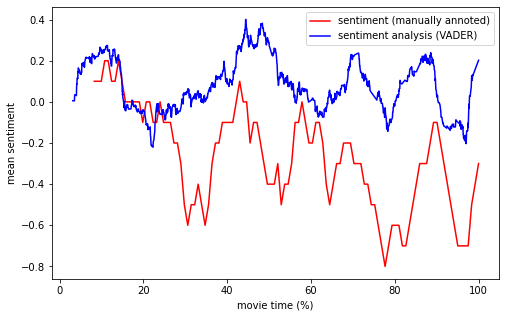

In [20]:
# Comparing sentiment arcs of annotations and subtitles; with VADER method; x-axis as percentage
estimated_sentiments = map_sentiment(subtitles, method='vader')
arc1 = sentiment_arc(annotations, window='10min', min_periods=10, normalize=True, name='sentiment (manually annoted)')
arc2 = sentiment_arc(estimated_sentiments, window='10min', normalize=True, scale=True, name='sentiment analysis (VADER)')
fig, ax = plt.subplots(figsize=(8, 5))
arc1.plot(color='red', ax=ax)
arc2.plot(color='blue', ax=ax)
ax.legend()
ax.set_xlabel('movie time (%)')
ax.set_ylabel('mean sentiment');

### 3b Quantitative evaluation

In [21]:
# Take subtitles with timestamps,
# Group them in 1 minute intervals,
# Apply VADER to the text of each 1 minute chunk
sid = nltk.sentiment.vader.SentimentIntensityAnalyzer()
padded = pd.Series([''], index=[pd.Timedelta('0:00:00')]).append(subtitles)
pred = padded.resample('1Min', label='right', closed='right').apply(lambda x: sid.polarity_scores(' '.join(x))['compound'])[annotations.index]
pred

0 days 00:01:00   -0.6174
0 days 00:02:00    0.4329
0 days 00:03:00   -0.5823
0 days 00:04:00    0.6654
0 days 00:05:00    0.9181
                    ...  
0 days 01:57:00    0.4404
0 days 01:58:00    0.5660
0 days 01:59:00   -0.5204
0 days 02:00:00    0.9344
0 days 02:01:00   -0.4137
Length: 121, dtype: float64

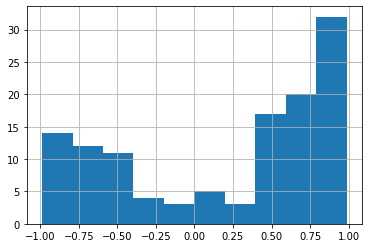

In [22]:
# Inspect distribution of VADER scores
pred.hist();

In [23]:
# Convert the continuous scores [-1, 1] to discrete labels {-1, 0, 1}
# Notice that we have to choose a threshold for when to consider a sentence positive (or negative).
predicted_labels_vader = [discretize_score(score, 0.5) for score in pred]
print(metrics.classification_report(annotations, predicted_labels_vader))

              precision    recall  f1-score   support

          -1       0.47      0.33      0.38        43
           0       0.59      0.29      0.39        65
           1       0.15      0.69      0.25        13

    accuracy                           0.35       121
   macro avg       0.40      0.44      0.34       121
weighted avg       0.50      0.35      0.37       121



In [24]:
# Confusion matrix; the correct predictions are in the diagonal from top-left to bottom-right, the rest are mistakes.
df = pd.DataFrame({
        'Actual': list(annotations),
        'Predicted': predicted_labels_vader})
pd.crosstab(df['Actual'], df['Predicted'])

Predicted,-1,0,1
Actual,,,
-1,14,11,18
0,14,19,32
1,2,2,9
